In [33]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import contextily as cx

In [5]:
engine= create_engine('sqlite:///mta_data.db')
engine.table_names()

['mta_data']

In [6]:
df=pd.read_sql('SELECT * FROM mta_data;',engine)

In [7]:
df.shape #10,927,991, x 11

(10927991, 11)

In [8]:
#clean data
df.columns = [column.strip() for column in df.columns]
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [9]:
#remove duplicate rows
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)    
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
10927990,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/31/2021,20:00:00,REGULAR,5562,1001,2021-12-31 20:00:00
10927989,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/31/2021,16:00:00,REGULAR,5562,1001,2021-12-31 16:00:00
10927988,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/31/2021,12:00:00,REGULAR,5562,1001,2021-12-31 12:00:00
10927987,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/31/2021,08:00:00,REGULAR,5562,1001,2021-12-31 08:00:00
10927986,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/31/2021,04:00:00,REGULAR,5562,1001,2021-12-31 04:00:00


In [10]:
#check to see if the duplicate has been removed
mask = ((df["C/A"] == "S101") & 
(df["UNIT"] == "R070") & 
(df["SCP"] == "00-00-02") & 
(df["STATION"] == "ST. GEORGE")&
(df["DATE_TIME"]=="2021-09-01 20:00:00"))

df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
3570536,S101,R070,00-00-02,ST. GEORGE,1,SRT,09/01/2021,20:00:00,REGULAR,1396413,324,2021-09-01 20:00:00


In [11]:
#check data for one turnstile
mask = ((df["C/A"] == "A002") & 
(df["UNIT"] == "R051") & 
(df["SCP"] == "02-00-00") & 
(df["STATION"] == "59 ST")&
(df["DATE"]=="09/01/2021"))

df[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
3362413,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2021,20:00:00,REGULAR,7628463,2610143,2021-09-01 20:00:00
3362412,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2021,16:00:00,REGULAR,7628256,2610111,2021-09-01 16:00:00
3362411,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2021,12:00:00,REGULAR,7628112,2610083,2021-09-01 12:00:00
3362410,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2021,08:00:00,REGULAR,7628051,2609949,2021-09-01 08:00:00
3362409,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2021,04:00:00,REGULAR,7628037,2609904,2021-09-01 04:00:00
3362408,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2021,00:00:00,REGULAR,7628030,2609899,2021-09-01 00:00:00


In [12]:
#pick last entry of the day to find max entries (data is sorted descending, so pick the first)
turnstiles_daily = (df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .agg({"ENTRIES":"first","EXITS":"first"})
)

In [13]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,01/01/2021,7511647,2558865
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996,2559007
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214,2559091
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754,2559328
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300,2559580


In [14]:
#what is the total entries/exits for a timestamp at a turnstile
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE","ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_daily.head()
                                            

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_3482/1190403995.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,01/01/2021,7511647,2558865,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996,2559007,01/01/2021,7511647.0,2558865.0
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214,2559091,01/02/2021,7511996.0,2559007.0
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754,2559328,01/03/2021,7512214.0,2559091.0
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300,2559580,01/04/2021,7512754.0,2559328.0


In [15]:
# Drop the rows for the earliest date_time stamp in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996,2559007,01/01/2021,7511647.0,2558865.0
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214,2559091,01/02/2021,7511996.0,2559007.0
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754,2559328,01/03/2021,7512214.0,2559091.0
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300,2559580,01/04/2021,7512754.0,2559328.0
5,A002,R051,02-00-00,59 ST,01/06/2021,7513790,2559817,01/05/2021,7513300.0,2559580.0


In [16]:
# What's the deal with counter being in reverse
mask = ((turnstiles_daily["C/A"] == "A011") & 
(turnstiles_daily["UNIT"] == "R080") & 
(turnstiles_daily["SCP"] == "01-03-00") & 
(turnstiles_daily["STATION"] == "57 ST-7 AV") &
(turnstiles_daily["DATE"]== "08/31/2021"))

turnstiles_daily[mask].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
14475,A011,R080,01-03-00,57 ST-7 AV,08/31/2021,885577465,489492692,08/30/2021,885577734.0,489493747.0


In [17]:
#calculate counts for entries

def get_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_counts, axis=1, max_counter=10000)

In [18]:
#calculate counts for exits

def get_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_counts, axis=1, max_counter=10000)

In [19]:
#check the calculation 
mask = ((turnstiles_daily["C/A"] == "A011") & 
(turnstiles_daily["UNIT"] == "R080") & 
(turnstiles_daily["SCP"] == "01-03-00") & 
(turnstiles_daily["STATION"] == "57 ST-7 AV") )

turnstiles_daily[mask].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
14234,A011,R080,01-03-00,57 ST-7 AV,01/02/2021,885629436,489698939,01/01/2021,885629558.0,489699509.0,122.0,570.0
14235,A011,R080,01-03-00,57 ST-7 AV,01/03/2021,885629336,489698567,01/02/2021,885629436.0,489698939.0,100.0,372.0
14236,A011,R080,01-03-00,57 ST-7 AV,01/04/2021,885629148,489697868,01/03/2021,885629336.0,489698567.0,188.0,699.0
14237,A011,R080,01-03-00,57 ST-7 AV,01/05/2021,885628924,489697074,01/04/2021,885629148.0,489697868.0,224.0,794.0
14238,A011,R080,01-03-00,57 ST-7 AV,01/06/2021,885628648,489696320,01/05/2021,885628924.0,489697074.0,276.0,754.0


In [20]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])['DAILY_ENTRIES','DAILY_EXITS'].sum().reset_index()
station_daily["DAILY_TOTALS"]= station_daily["DAILY_ENTRIES"]+station_daily["DAILY_EXITS"]
station_daily.head()

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_3482/546621034.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_daily = turnstiles_daily.groupby(["STATION", "DATE"])['DAILY_ENTRIES','DAILY_EXITS'].sum().reset_index()


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS
0,1 AV,01/02/2021,3673.0,6054.0,9727.0
1,1 AV,01/03/2021,2547.0,4537.0,7084.0
2,1 AV,01/04/2021,5303.0,8145.0,13448.0
3,1 AV,01/05/2021,5468.0,8332.0,13800.0
4,1 AV,01/06/2021,5603.0,8532.0,14135.0


In [21]:
prcp_df = pd.read_csv('daily_prcp_2021.csv')
prcp_df =  prcp_df[['date','prcp','snow']]

In [22]:
#merge precipitation data with turnstile data
turnstiles_daily_prcp = pd.merge(station_daily
                            , prcp_df
                            , how='left' 
                            , left_on=['DATE']
                            , right_on=['date']
)


In [23]:
turnstiles_daily_prcp

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,date,prcp,snow
0,1 AV,01/02/2021,3673.0,6054.0,9727.0,01/02/2021,1.5,0
1,1 AV,01/03/2021,2547.0,4537.0,7084.0,01/03/2021,4.1,0
2,1 AV,01/04/2021,5303.0,8145.0,13448.0,01/04/2021,0.3,0
3,1 AV,01/05/2021,5468.0,8332.0,13800.0,01/05/2021,0.0,0
4,1 AV,01/06/2021,5603.0,8532.0,14135.0,01/06/2021,0.0,0
...,...,...,...,...,...,...,...,...
137661,ZEREGA AV,12/27/2021,840.0,1151.0,1991.0,12/27/2021,2.0,0
137662,ZEREGA AV,12/28/2021,920.0,1175.0,2095.0,12/28/2021,1.3,0
137663,ZEREGA AV,12/29/2021,904.0,1130.0,2034.0,12/29/2021,4.1,0
137664,ZEREGA AV,12/30/2021,859.0,1159.0,2018.0,12/30/2021,1.3,0


In [24]:
#sum up all entrie/exits on a day to run scatterplot/regression
daily_summary = turnstiles_daily_prcp.groupby(["DATE","prcp"]).agg({"DAILY_TOTALS":"sum"}).reset_index()
daily_summary.sort_values("DAILY_TOTALS", ascending= False)

,DATE,prcp,DAILY_TOTALS
341,12/09/2021,0.0,5982267.0
320,11/18/2021,1.3,5947036.0
342,12/10/2021,0.0,5908537.0
340,12/08/2021,1.0,5899313.0
312,11/10/2021,0.0,5891825.0
...,...,...,...
22,01/24/2021,0.0,1503735.0
29,01/31/2021,1.3,1459757.0
1,01/03/2021,4.1,1373794.0
36,02/07/2021,9.9,1340958.0


/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


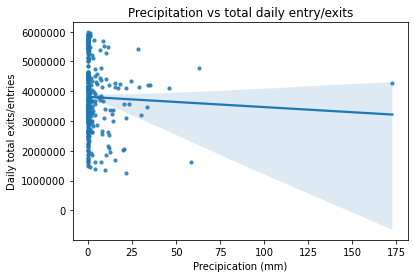

In [25]:
x= daily_summary.prcp
y= daily_summary.DAILY_TOTALS

plt.figure(facecolor='white')

ax =sns.regplot(x,y,scatter_kws={'s':10})

ax.set(xlabel = "Precipication (mm)",
        ylabel= "Daily total exits/entries",
        title = "Precipitation vs total daily entry/exits")

plt.ticklabel_format(style="plain",axis='y')
plt.savefig('prcp_vs_entries_exits.png')

In [26]:
#calculate correlations between Daily Totals x prcp and Daily Totals x snow
df_prcp_subset= turnstiles_daily_prcp.loc[:, ['DAILY_TOTALS','prcp']]
df_prcp_subset


df_prcp_subset_corr = pd.DataFrame(np.corrcoef(df_prcp_subset.T)) # corrcoef function calculates row based correlations by default, but we want column correlations
df_prcp_subset_corr.columns= ['DAILY_TOTALS','prcp']
df_prcp_subset_corr.index= ['DAILY_TOTALS','prcp']
df_prcp_subset_corr


dfi.export(df_prcp_subset_corr, 'correlation.png')

[0125/124500.736734:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/: Operation not permitted (1)
[0125/124500.738785:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0125/124500.743715:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/: Operation not permitted (1)
[0125/124503.652462:INFO:headless_shell.cc(653)] Written to file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/tmp0110vwub/temp.png.


In [27]:
# run correlation by station
df_prcp_station_subset= turnstiles_daily_prcp.loc[:, ['STATION','DAILY_TOTALS','prcp']]
df_prcp_station_subset

corr = df_prcp_station_subset.groupby('STATION')[['DAILY_TOTALS','prcp']].corr()
corr


DAILY_TOTALS      prcp
STATION                                           
1 AV          DAILY_TOTALS      1.000000 -0.026889
              prcp             -0.026889  1.000000
103 ST        DAILY_TOTALS      1.000000 -0.026580
              prcp             -0.026580  1.000000
103 ST-CORONA DAILY_TOTALS      1.000000 -0.015755
...                                  ...       ...
WTC-CORTLANDT prcp             -0.040326  1.000000
YORK ST       DAILY_TOTALS      1.000000 -0.039648
              prcp             -0.039648  1.000000
ZEREGA AV     DAILY_TOTALS      1.000000 -0.030807
              prcp             -0.030807  1.000000

[758 rows x 2 columns]

In [28]:
corr_series=pd.DataFrame(df_prcp_station_subset.groupby('STATION')[['DAILY_TOTALS','prcp']].corr().iloc[0::2,-1]).reset_index()
corr_df=corr_series[["STATION","prcp"]]
corr_df.sort_values("prcp",ascending= True)

,STATION,prcp
330,RIT-ROOSEVELT,-0.188326
329,RIT-MANHATTAN,-0.181363
120,AQUEDUCT N.COND,-0.110041
117,9TH STREET,-0.092444
241,HIGH ST,-0.090189
...,...,...
240,HEWES ST,0.022044
243,HOWARD BCH JFK,0.030097
186,CLARK ST,0.040543
163,BROAD ST,0.069876


In [29]:
#find top 10 negatively correlated stations
top_neg_corr = corr_df.sort_values("prcp",ascending=True).head(10).set_index("STATION")
top_neg_corr.rename(columns={"STATION": "Station", "prcp": "Correlation"},inplace=True)
image=top_neg_corr.style.background_gradient(cmap ='Reds_r')

dfi.export(image, 'top_neg_corr.png')

image

[0125/124505.944991:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/: Operation not permitted (1)
[0125/124505.947396:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0125/124505.953261:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/: Operation not permitted (1)
[0125/124507.527221:INFO:headless_shell.cc(653)] Written to file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/tmp0kj44j39/temp.png.


,Correlation
STATION,
RIT-ROOSEVELT,-0.188326
RIT-MANHATTAN,-0.181363
AQUEDUCT N.COND,-0.110041
9TH STREET,-0.092444
HIGH ST,-0.090189
CENTRAL PK N110,-0.089969
THIRTY THIRD ST,-0.082308
14TH STREET,-0.080730
74 ST-BROADWAY,-0.080674


In [30]:
#find top 10 negatively correlated stations
top_pos_corr = corr_df.sort_values("prcp",ascending=False).head(10).set_index("STATION")
top_pos_corr.rename(columns={"STATION": "Station", "prcp": "Correlation"},inplace=True)
image=top_pos_corr.style.background_gradient(cmap ='Blues')

dfi.export(image, 'top_pos_corr.png')

image

[0125/124508.365272:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/: Operation not permitted (1)
[0125/124508.366892:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0125/124508.369012:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/: Operation not permitted (1)
[0125/124509.463387:INFO:headless_shell.cc(653)] Written to file /var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/tmpg16ca4au/temp.png.


,Correlation
STATION,
METS-WILLETS PT,0.083597
BROAD ST,0.069876
CLARK ST,0.040543
HOWARD BCH JFK,0.030097
HEWES ST,0.022044
JFK JAMAICA CT1,0.020262
E 143/ST MARY'S,0.019920
HUNTERS PT AV,0.018867
68ST-HUNTER CO,0.017549


In [34]:
#Mapping 
locations = pd.read_csv('nyc_transit_location_data.csv')
locations = locations[["Station Name","Station Latitude","Station Longitude"]]

#append manually missing station
line =pd.DataFrame({"Station Name":"RIT-MANHATTAN",
"Station Latitude" : 40.76145580411147,
"Station Longitude":-73.96407878223238,
"geometry":"POINT (40.76146 -73.96408)"},index=[1868])
locations= locations.append(line)


geometry = [Point(xy) for xy in zip(locations["Station Latitude"], locations["Station Longitude"])]
gdf = GeoDataFrame(locations, geometry=geometry)
gdf.set_crs(epsg=4326, inplace = True)

#only extract rows we're interested in
gdf_subset= gdf.iloc[[1677,1868,739,733,1295,20,365,120,916,821],:].append( #top decreases
 gdf.iloc[[1501,900,1034,1306,1293,1359,1108,1317,612,1093],:]).reset_index()

#prep data for mapping
corrs= top_neg_corr.append(top_pos_corr).reset_index()
merged_gdf = pd.merge(gdf_subset,corrs,left_index=True, right_index=True)
merged_gdf


,index,Station Name,Station Latitude,Station Longitude,geometry,STATION,Correlation
0,1677,Roosevelt Island,40.759145,-73.953260,POINT (40.75914 -73.95326),RIT-ROOSEVELT,-0.188326
1,1868,RIT-MANHATTAN,40.761456,-73.964079,POINT (40.76146 -73.96408),RIT-MANHATTAN,-0.181363
2,739,Aqueduct-North Conduit Av,40.668234,-73.834058,POINT (40.66823 -73.83406),AQUEDUCT N.COND,-0.110041
3,733,9th St,40.670847,-73.988302,POINT (40.67085 -73.98830),9TH STREET,-0.092444
4,1295,High St,40.699337,-73.990531,POINT (40.69934 -73.99053),HIGH ST,-0.090189
5,20,110th St-Central Park North,40.799075,-73.951822,POINT (40.79908 -73.95182),CENTRAL PK N110,-0.089969
6,365,33rd St,40.746081,-73.982076,POINT (40.74608 -73.98208),THIRTY THIRD ST,-0.082308
7,120,14th St,40.738228,-73.996209,POINT (40.73823 -73.99621),14TH STREET,-0.080730
8,916,Broadway-74th St,40.746848,-73.891394,POINT (40.74685 -73.89139),74 ST-BROADWAY,-0.080674
9,821,Beach 90th St,40.588034,-73.813641,POINT (40.58803 -73.81364),BEACH 90 ST,-0.079236


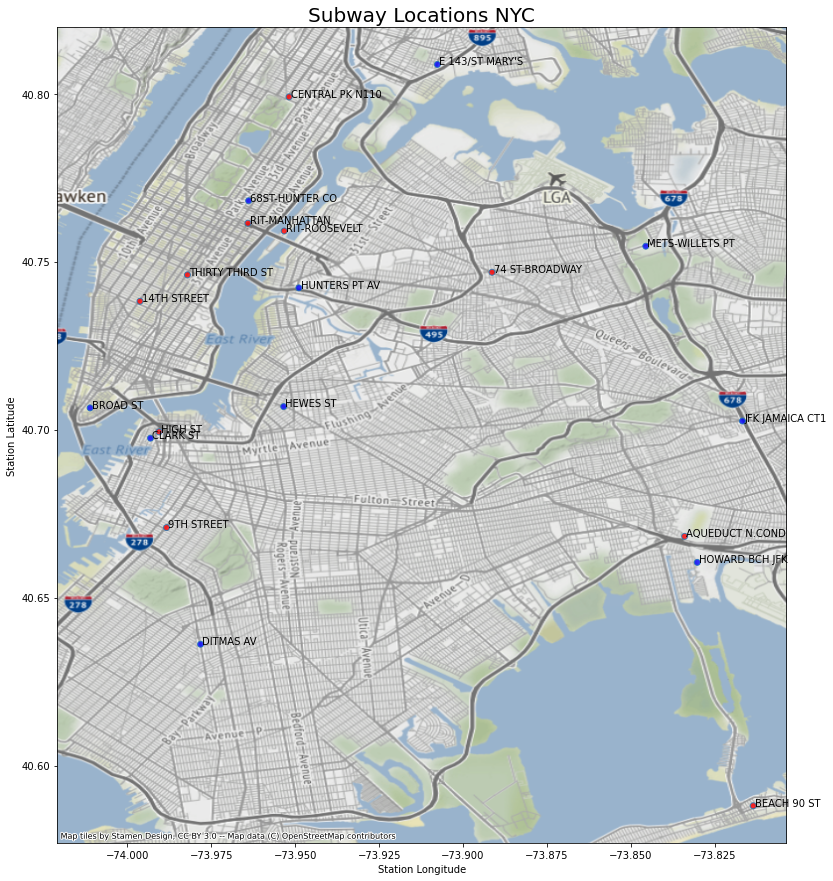

<Figure size 432x288 with 0 Axes>

In [43]:
#Mapping

#customize color of stations & plot
value=(merged_gdf['Correlation']<0)
merged_gdf['color']= np.where( value==True , "r", "b")

ax=sns.regplot(data=merged_gdf, x="Station Longitude", y="Station Latitude",
          fit_reg=False, marker="o", scatter_kws={'facecolor':merged_gdf['color']})
ax.figure.set_size_inches(15,15)

cx.add_basemap(ax, crs='EPSG:4326') 
# add annotations one by one with a loop
for line in range(0,merged_gdf.shape[0]):
     plt.text(merged_gdf["Station Longitude"][line]+0.0005, merged_gdf["Station Latitude"][line], merged_gdf["STATION"][line],
     horizontalalignment='left', size='medium', color='black', weight='normal')

plt.title("Subway Locations NYC", size=20)
plt.show()
plt.savefig('map_corr.png')